In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from transformers import logging

logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [3]:
from models import *

In [4]:
Classifiers = [EmbeddingClassifier, HiddenClassifier1, HiddenClassifier2, HiddenClassifier3, HiddenClassifier4,
               HiddenClassifier5, HiddenClassifier6, HiddenClassifier7, HiddenClassifier8, HiddenClassifier9,
               HiddenClassifier10, HiddenClassifier11, HiddenClassifier12]

In [5]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
input_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")

In [6]:
vc = input_df[label_column].value_counts()
down_sample_vc = vc[vc.values < 1500]
input_df = input_df[input_df[label_column].isin(down_sample_vc.index)]

In [7]:
running_device = torch.device("cuda")

In [8]:
prd = ProcessData(input_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
suf_df,insuf_df,_, label_encoder, onehot = prd.process()
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
suf_df, insuf_df = prd._split_sufficient_insufficient(train_df)

After removing duplicate sentence: 16897
After drop cpv with low observations we have : 16803
The num of class is  30
The number of total data is:  15992
Total number of test data is:  900
Total number of train data is:  15092


In [9]:
value_counts = insuf_df[label_column].value_counts()
model_runner = RunModel(running_device)

In [10]:
train_df[label_column].value_counts()

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [11]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [12]:
aug_limits = decide_aug_labels(True, 970, value_counts,0.5)

In [13]:
aug_limits

{'Vervoersdiensten (uitg. vervoer van afval)': 49,
 'Diensten voor onderwijs en opleiding': 129,
 'Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur': 154,
 'Overige gemeenschaps-,  sociale en persoonlijke diensten': 177,
 'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)': 188,
 'Structuren en materialen voor de bouw; ondersteunende producten voor de bouw (uitgezonderd elektrische apparatuur)': 201,
 'Onderzoek en ontwikkeling, en aanverwante adviezen': 217,
 'Bedrijfsmachines': 231,
 'Post- en telecommunicatiediensten': 329,
 'Drukwerk en aanverwante producten': 404,
 'Kleding, schoeisel, bagageartikelen en accessoires': 422,
 'Diensten voor openbaar bestuur, defensie en sociale verzekering': 432,
 'Uitrusting voor veiligheid, brandweer, politie en leger': 537,
 'Cultuur-, sport- en recreatiediensten': 570,
 'Diensten voor hotel, restaurant en detailhandel': 571,
 'Elektrische machines, apparaten, uitrusting en v

In [14]:
ACCs = []
F1s = []
Precisions = []
Recalls = []
Label_f1s = []
for layer_index in range(13):
    cd = CreateDataset(text_column, label_column, label_encoder, onehot, layer_index, running_device, max_length=120)
    test_dataset = cd.create(test_df)
    test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
    insuf_ds_dict = cd.create_label_dataset(insuf_df)
    insuf_ds_list = list(insuf_ds_dict.values())
    augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
    gan_aug_train_dataset = torch.utils.data.ConcatDataset(augmented_ds_lists + insuf_ds_list)
    gan_train_dl = DataLoader(gan_aug_train_dataset, shuffle=True, batch_size=20)
    Classifier = Classifiers[layer_index]
    classifier = Classifier(prd.num_class, bert)
    classifier = model_runner.train_classifier(gan_train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
    predictions, labels = model_runner.predict(test_dl, classifier)
    acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
    ACCs.append(acc)
    F1s.append(f1)
    Precisions.append(precision)
    Recalls.append(recall)
    Label_f1s.append(label_f1)

Getting bert hidden states from layer: 0: 100%|██████████| 769/769 [00:09<00:00, 84.63it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [09:43<00:00,  2.47it/s]


0 train loss:  2.063940165074248 val acc:  0.4833333412806193


100%|██████████| 1444/1444 [09:43<00:00,  2.47it/s]


1 train loss:  0.8056213388585813 val acc:  0.5866666820314196


100%|██████████| 1444/1444 [09:43<00:00,  2.47it/s]


2 train loss:  0.5042971593516149 val acc:  0.6288889010747274


100%|██████████| 1444/1444 [09:43<00:00,  2.47it/s]


3 train loss:  0.3533148733844821 val acc:  0.6455555670791202


100%|██████████| 1444/1444 [09:43<00:00,  2.47it/s]


4 train loss:  0.25764802744975857 val acc:  0.6444444576899211


100%|██████████| 1444/1444 [09:43<00:00,  2.48it/s]


5 train loss:  0.1872749709768654 val acc:  0.6511111239592234


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.651
F1: 0.631
Precision: 0.647
Recall: 0.651


Getting bert hidden states from layer: 1: 100%|██████████| 769/769 [00:08<00:00, 85.47it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [08:53<00:00,  2.71it/s]


0 train loss:  2.28351995225098 val acc:  0.5122222350703345


100%|██████████| 1444/1444 [08:53<00:00,  2.71it/s]


1 train loss:  0.8897312108705909 val acc:  0.5833333479033576


100%|██████████| 1444/1444 [08:53<00:00,  2.71it/s]


2 train loss:  0.6041938328052615 val acc:  0.6122222383817036


100%|██████████| 1444/1444 [08:53<00:00,  2.70it/s]


3 train loss:  0.46261025686332974 val acc:  0.6044444567627377


100%|██████████| 1444/1444 [08:54<00:00,  2.70it/s]


4 train loss:  0.36001463704858583 val acc:  0.6177777926127116


100%|██████████| 1444/1444 [08:54<00:00,  2.70it/s]


5 train loss:  0.29228356568893504 val acc:  0.6233333488305409


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.623
F1: 0.594
Precision: 0.613
Recall: 0.623


Getting bert hidden states from layer: 2: 100%|██████████| 769/769 [00:09<00:00, 85.30it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [08:04<00:00,  2.98it/s]


0 train loss:  2.0855838885102576 val acc:  0.49222223295105827


100%|██████████| 1444/1444 [08:04<00:00,  2.98it/s]


1 train loss:  0.7433045380993893 val acc:  0.5866666780577765


100%|██████████| 1444/1444 [08:04<00:00,  2.98it/s]


2 train loss:  0.4775487172038106 val acc:  0.6055555701255798


100%|██████████| 1444/1444 [08:05<00:00,  2.98it/s]


3 train loss:  0.3397360987705888 val acc:  0.6333333465788099


100%|██████████| 1444/1444 [08:05<00:00,  2.98it/s]


4 train loss:  0.24388289349050443 val acc:  0.6422222303019629


100%|██████████| 1444/1444 [08:05<00:00,  2.97it/s]


5 train loss:  0.17127555727035096 val acc:  0.6477777898311615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.626
Precision: 0.667
Recall: 0.648


Getting bert hidden states from layer: 3: 100%|██████████| 769/769 [00:09<00:00, 82.73it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [07:16<00:00,  3.31it/s]


0 train loss:  2.113649759059798 val acc:  0.46222223076555463


100%|██████████| 1444/1444 [07:14<00:00,  3.32it/s]


1 train loss:  0.8714529072809087 val acc:  0.5666666792498695


100%|██████████| 1444/1444 [07:15<00:00,  3.31it/s]


2 train loss:  0.5361584895845101 val acc:  0.6077777902285258


100%|██████████| 1444/1444 [07:15<00:00,  3.32it/s]


3 train loss:  0.3891662546946897 val acc:  0.6288888990879059


100%|██████████| 1444/1444 [07:15<00:00,  3.32it/s]


4 train loss:  0.2939519268722426 val acc:  0.6444444543785519


100%|██████████| 1444/1444 [07:15<00:00,  3.31it/s]


5 train loss:  0.21431424286522208 val acc:  0.6511111226346757


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.651
F1: 0.628
Precision: 0.660
Recall: 0.651


Getting bert hidden states from layer: 4: 100%|██████████| 769/769 [00:09<00:00, 83.43it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [06:25<00:00,  3.75it/s]


0 train loss:  2.147803142254042 val acc:  0.45666667620340984


100%|██████████| 1444/1444 [06:24<00:00,  3.75it/s]


1 train loss:  0.9290993287437015 val acc:  0.5766666836208767


100%|██████████| 1444/1444 [06:25<00:00,  3.74it/s]


2 train loss:  0.6349697858301556 val acc:  0.5933333456516265


100%|██████████| 1444/1444 [06:25<00:00,  3.74it/s]


3 train loss:  0.4923643025781165 val acc:  0.6122222363948822


100%|██████████| 1444/1444 [06:25<00:00,  3.74it/s]


4 train loss:  0.39271972093078467 val acc:  0.6177777932749854


100%|██████████| 1444/1444 [06:25<00:00,  3.75it/s]


5 train loss:  0.3142811836248491 val acc:  0.6155555698606703


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.616
F1: 0.581
Precision: 0.605
Recall: 0.616


Getting bert hidden states from layer: 5: 100%|██████████| 769/769 [00:10<00:00, 76.34it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


0 train loss:  2.115849850167858 val acc:  0.4522222313616011


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


1 train loss:  0.9480451332957296 val acc:  0.565555567211575


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


2 train loss:  0.7084790237268582 val acc:  0.5877777887715234


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


3 train loss:  0.5819178623485268 val acc:  0.5944444557030996


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


4 train loss:  0.4910077563167093 val acc:  0.5922222329510582


100%|██████████| 1444/1444 [05:35<00:00,  4.30it/s]


5 train loss:  0.41215300778832564 val acc:  0.5877777924140294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.588
F1: 0.554
Precision: 0.608
Recall: 0.588


Getting bert hidden states from layer: 6: 100%|██████████| 769/769 [00:09<00:00, 79.52it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [04:46<00:00,  5.03it/s]


0 train loss:  2.132870432515719 val acc:  0.4933333436648051


100%|██████████| 1444/1444 [04:45<00:00,  5.05it/s]


1 train loss:  0.9595569391164753 val acc:  0.5644444551732805


100%|██████████| 1444/1444 [04:46<00:00,  5.04it/s]


2 train loss:  0.7294461997251679 val acc:  0.6000000105963813


100%|██████████| 1444/1444 [04:46<00:00,  5.03it/s]


3 train loss:  0.6055693364885334 val acc:  0.6055555674764845


100%|██████████| 1444/1444 [04:47<00:00,  5.02it/s]


4 train loss:  0.5098746782704063 val acc:  0.6277777930100759


100%|██████████| 1444/1444 [04:46<00:00,  5.04it/s]


5 train loss:  0.4330360878673653 val acc:  0.632222232553694


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.632
F1: 0.592
Precision: 0.594
Recall: 0.632


Getting bert hidden states from layer: 7: 100%|██████████| 769/769 [00:09<00:00, 79.64it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [03:57<00:00,  6.09it/s]


0 train loss:  2.1068664646998996 val acc:  0.46666667527622646


100%|██████████| 1444/1444 [03:55<00:00,  6.13it/s]


1 train loss:  0.9659018451528536 val acc:  0.5511111259460449


100%|██████████| 1444/1444 [03:56<00:00,  6.10it/s]


2 train loss:  0.723164465959465 val acc:  0.5733333435323503


100%|██████████| 1444/1444 [03:55<00:00,  6.13it/s]


3 train loss:  0.475650738045016 val acc:  0.5955555637677511


100%|██████████| 1444/1444 [03:56<00:00,  6.12it/s]


4 train loss:  0.3543721963961059 val acc:  0.616666681236691


100%|██████████| 1444/1444 [03:56<00:00,  6.11it/s]


5 train loss:  0.26267271516444757 val acc:  0.6177777899636163


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.618
F1: 0.597
Precision: 0.638
Recall: 0.618


Getting bert hidden states from layer: 8: 100%|██████████| 769/769 [00:09<00:00, 78.52it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [03:09<00:00,  7.63it/s]


0 train loss:  2.273082699389339 val acc:  0.42000000675519306


100%|██████████| 1444/1444 [03:08<00:00,  7.65it/s]


1 train loss:  1.1176333609153195 val acc:  0.502222232023875


100%|██████████| 1444/1444 [03:09<00:00,  7.62it/s]


2 train loss:  0.8956827070677544 val acc:  0.5300000117884742


100%|██████████| 1444/1444 [03:09<00:00,  7.61it/s]


3 train loss:  0.7490723986059964 val acc:  0.5488889005449084


100%|██████████| 1444/1444 [03:08<00:00,  7.65it/s]


4 train loss:  0.6027657851432334 val acc:  0.5688889039887323


100%|██████████| 1444/1444 [03:09<00:00,  7.62it/s]


5 train loss:  0.5075359967023836 val acc:  0.5644444558355544


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.564
F1: 0.524
Precision: 0.526
Recall: 0.564


Getting bert hidden states from layer: 9: 100%|██████████| 769/769 [00:09<00:00, 79.64it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [02:19<00:00, 10.35it/s]


0 train loss:  2.223575807922104 val acc:  0.4144444511996375


100%|██████████| 1444/1444 [02:19<00:00, 10.33it/s]


1 train loss:  1.077501346581613 val acc:  0.5111111230320401


100%|██████████| 1444/1444 [02:19<00:00, 10.34it/s]


2 train loss:  0.8450174587017694 val acc:  0.536666680044598


100%|██████████| 1444/1444 [02:19<00:00, 10.34it/s]


3 train loss:  0.7263255134931768 val acc:  0.5411111222373115


100%|██████████| 1444/1444 [02:19<00:00, 10.32it/s]


4 train loss:  0.6351728307578579 val acc:  0.5600000109937456


100%|██████████| 1444/1444 [02:20<00:00, 10.31it/s]


5 train loss:  0.5574169559017278 val acc:  0.5666666799121433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.519
Precision: 0.518
Recall: 0.567


Getting bert hidden states from layer: 10: 100%|██████████| 769/769 [00:09<00:00, 84.07it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [01:29<00:00, 16.06it/s]


0 train loss:  2.4207111662279535 val acc:  0.36444444954395294


100%|██████████| 1444/1444 [01:29<00:00, 16.07it/s]


1 train loss:  1.238217872874476 val acc:  0.4933333436648051


100%|██████████| 1444/1444 [01:29<00:00, 16.10it/s]


2 train loss:  0.9571969467124946 val acc:  0.5133333477709029


100%|██████████| 1444/1444 [01:29<00:00, 16.09it/s]


3 train loss:  0.8377666840654826 val acc:  0.5377777947319878


100%|██████████| 1444/1444 [01:29<00:00, 16.06it/s]


4 train loss:  0.7545074272715071 val acc:  0.5366666793823243


100%|██████████| 1444/1444 [01:30<00:00, 16.03it/s]


5 train loss:  0.6771765804005957 val acc:  0.5444444557030995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.500
Precision: 0.534
Recall: 0.544


Getting bert hidden states from layer: 11: 100%|██████████| 769/769 [00:09<00:00, 79.81it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:43<00:00, 33.06it/s]


0 train loss:  2.6254766689112974 val acc:  0.16111111318071683


100%|██████████| 1444/1444 [00:43<00:00, 33.05it/s]


1 train loss:  1.5842291316910133 val acc:  0.36555556191338434


100%|██████████| 1444/1444 [00:43<00:00, 33.06it/s]


2 train loss:  1.25906457044081 val acc:  0.4400000082121955


100%|██████████| 1444/1444 [00:43<00:00, 33.07it/s]


3 train loss:  1.1432544769321948 val acc:  0.47111112078030903


100%|██████████| 1444/1444 [00:43<00:00, 33.06it/s]


4 train loss:  1.075528096779149 val acc:  0.4733333432012134


100%|██████████| 1444/1444 [00:43<00:00, 33.05it/s]


5 train loss:  1.0225134348004046 val acc:  0.49000001152356465


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.490
F1: 0.427
Precision: 0.414
Recall: 0.490


Getting bert hidden states from layer: 12: 100%|██████████| 769/769 [00:09<00:00, 81.66it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:06<00:00, 224.09it/s]


0 train loss:  2.8500859219776955 val acc:  0.06000000105963813


100%|██████████| 1444/1444 [00:06<00:00, 237.86it/s]


1 train loss:  2.018002859855953 val acc:  0.10444444682863023


100%|██████████| 1444/1444 [00:06<00:00, 228.92it/s]


2 train loss:  1.8544914429785473 val acc:  0.11666666815678278


100%|██████████| 1444/1444 [00:06<00:00, 230.05it/s]


3 train loss:  1.755658786506534 val acc:  0.16222222538457975


100%|██████████| 1444/1444 [00:06<00:00, 230.17it/s]


4 train loss:  1.6864853142618803 val acc:  0.17333333533671166


100%|██████████| 1444/1444 [00:06<00:00, 236.37it/s]


5 train loss:  1.6294979054759413 val acc:  0.20000000364250606
Total ACC: 0.200
F1: 0.143
Precision: 0.147
Recall: 0.200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


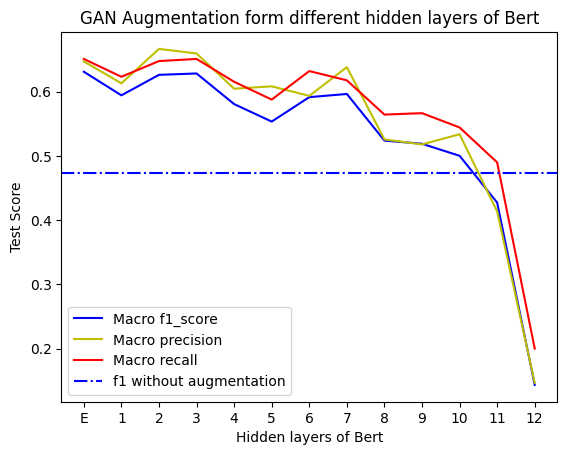

In [28]:
x_label=["E"]+[i for i in range(1,13)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(F1s, label="Macro f1_score",color='b')
plt.plot(Precisions, label="Macro precision",color='y')
plt.plot(Recalls, label="Macro recall",color='r')
# plt.text(x, y, s, fontdict=None, **kwargs)[source]

plt.axhline(y = 0.473, color = 'b', linestyle = 'dashdot',label="f1 without augmentation")
plt.xticks([i for i in range(13)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [35]:
all_fls=np.array(Label_f1s)

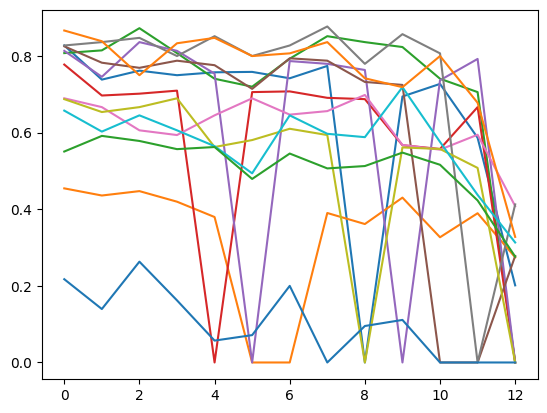

In [37]:
for i in range(len(all_fls)):
  plt.plot(all_fls[:,i])
plt.show()

In [42]:
print(all_fls)

[[0.82758621 0.45454545 0.80769231 0.77777778 0.81355932 0.82539683
  0.68965517 0.82758621 0.6875     0.65753425 0.2173913  0.86666667
  0.55072464 0.74193548 0.87272727 0.         0.69230769 0.55072464
  0.         0.77419355 0.47826087 0.61290323 0.31578947 0.55
  0.89230769 0.6984127  0.45544554 0.62686567 0.95238095 0.71698113]
 [0.73846154 0.43589744 0.81481481 0.6969697  0.74576271 0.7826087
  0.66666667 0.83636364 0.65384615 0.60273973 0.13953488 0.83870968
  0.5915493  0.70967742 0.85714286 0.         0.74576271 0.59016393
  0.23529412 0.         0.44       0.57142857 0.31818182 0.55696203
  0.9        0.64864865 0.47058824 0.64615385 0.90909091 0.68965517]
 [0.76190476 0.44736842 0.87272727 0.70175439 0.83636364 0.76923077
  0.60606061 0.84745763 0.66666667 0.64516129 0.26315789 0.75
  0.57831325 0.73015873 0.82142857 0.         0.68852459 0.57142857
  0.18181818 0.71875    0.47826087 0.66666667 0.35897436 0.57142857
  0.87878788 0.67741935 0.47191011 0.61111111 0.90625    0.

In [45]:
label_encoder.inverse_transform([i for i in range(prd.num_class)])

array(['Aardolieproducten, brandstof, elektriciteit en andere energiebronnen',
       'Bedrijfsmachines', 'Chemische producten',
       'Cultuur-, sport- en recreatiediensten',
       'Diensten voor hotel, restaurant en detailhandel',
       'Diensten voor onderwijs en opleiding',
       'Diensten voor openbaar bestuur, defensie en sociale verzekering',
       'Drukwerk en aanverwante producten',
       'Elektrische machines, apparaten, uitrusting en verbruiksartikelen. Verlichting',
       'Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten',
       'Installatiediensten (uitgezonderd software)',
       'Kleding, schoeisel, bagageartikelen en accessoires',
       'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)',
       'Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten',
       'Landbouwmachines',
       'Machines voor de mijnbou

In [48]:
for i in range(prd.num_class):
    label=label_encoder.inverse_transform([i])
    print(all_fls[:,i])
    print(value_counts[label])

[0.82758621 0.73846154 0.76190476 0.75       0.75757576 0.75862069
 0.74193548 0.77419355 0.         0.69444444 0.72727273 0.58666667
 0.20134228]
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen    970
Name: afdeling, dtype: int64
[0.45454545 0.43589744 0.44736842 0.41975309 0.37974684 0.
 0.         0.3902439  0.36144578 0.43037975 0.32692308 0.38961039
 0.2745098 ]
Bedrijfsmachines    739
Name: afdeling, dtype: int64
[0.80769231 0.81481481 0.87272727 0.80769231 0.74074074 0.72
 0.79310345 0.85185185 0.83636364 0.82352941 0.74074074 0.70588235
 0.        ]
Chemische producten    167
Name: afdeling, dtype: int64
[0.77777778 0.6969697  0.70175439 0.70967742 0.         0.70588235
 0.70769231 0.69090909 0.6875     0.56716418 0.55737705 0.66666667
 0.        ]
Cultuur-, sport- en recreatiediensten    400
Name: afdeling, dtype: int64
[0.81355932 0.74576271 0.83636364 0.81355932 0.75409836 0.
 0.78688525 0.77966102 0.76363636 0.         0.73684211 0.79245283
 0.        ]

In [15]:
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(insuf_df)
insuf_ds_list = list(insuf_ds_dict.values())
train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
Classifier = Classifiers[0]
classifier = Classifier(prd.num_class, bert)
classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


0 train loss:  3.1997555467466645 val acc:  0.28777778281105887


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


1 train loss:  2.0998171910544894 val acc:  0.4266666756735908


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


2 train loss:  1.4319441424300339 val acc:  0.49555556211206647


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


3 train loss:  1.0823064050137603 val acc:  0.5255555669466655


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


4 train loss:  0.8565918920253286 val acc:  0.5455555674102571


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


5 train loss:  0.7038976163362826 val acc:  0.536666684018241
Total ACC: 0.537
F1: 0.473
Precision: 0.440
Recall: 0.537


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
